In [18]:
import numpy as np
import math, json
from rdp import rdp
import glob
import io
import base64
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [61]:
def create_data(drawing):
    post_data = []
    new_data = []
    total_len_strokes = 0
    xs = []
    ys = []
    for item in drawing:
        char = list(item.keys())[0]
        stroke = item[char]
        if len(stroke) > 1:
            post_stroke = rdp(stroke)
            for x, y in post_stroke:
                post_data.append([500-x, y])
                
            for j, (x, y) in enumerate(stroke):
                z = 0 
                if j == len(stroke) - 1:
                    z = 1
                new_data.append([x, y, z])
        elif len(stroke) == 1:
            x, y = stroke[0]
            new_data.append([x, y, 0])
            new_data.append([x+5, y+5, 1])
                

    return new_data, post_data

In [62]:
def map_axes(i, num_sketches = 4):
    sqrt = int(math.sqrt(num_sketches))
    x = np.array(list(range(num_sketches))).reshape((sqrt, sqrt)) 
    dim1, dim2 = np.where(x == i)
    return (int(dim1), int(dim2))
    

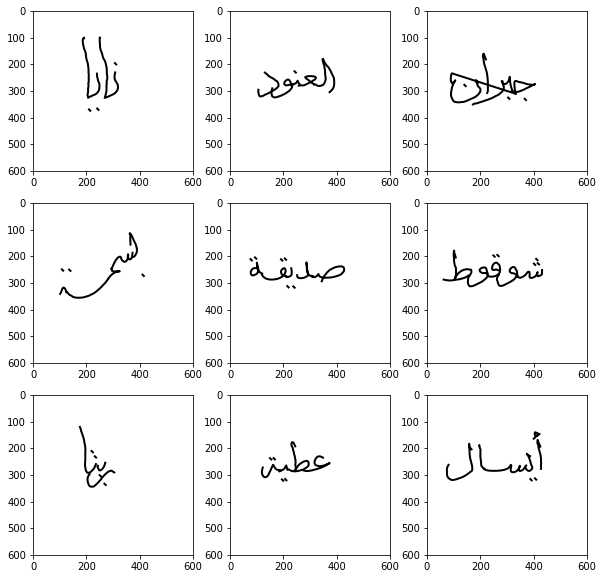

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

num_sketches = 9
npy_files = glob.glob('server/data/*')
mx = 0 
    
def data_gen():
    global mx
    drawings = []

    for file in npy_files[0:num_sketches]:
        drawing, _ = create_data(json.load(open(file))) 
        drawings.append(drawing)
        mx = max(len(drawing), mx)

    for drawing in drawings:
        if len(drawing) < mx:
            while len(drawing) < mx:
                drawing.append(drawing[-1])

    for i in range(mx):
        points = []
        for j in range(num_sketches):
            points.append(drawings[j][i])
        yield points

sqrt = int(math.sqrt(num_sketches))
fig, axes = plt.subplots(sqrt, sqrt, figsize=(10,10))
lines = []

for i in range(num_sketches):
    ax = axes[map_axes(i, num_sketches = num_sketches)]
    ax.set_ylim(600, 0)
    ax.set_xlim(0, 600)
    ax.set_aspect('equal', adjustable='box')
    line, = ax.plot([], [], lw=2, color = 'k')
    lines.append(line) 
    
# initialize the data arrays 
line_data = [([], []) for _ in range(num_sketches)]

def run(data):
    global line_data, num_sketches
    for i in range(num_sketches):
        x, y, z = data[i]
        line_data[i][0].append(x)
        line_data[i][1].append(y)
        lines[i].set_data(line_data[i][0], line_data[i][1])
        if z == 1:
            line, = axes[map_axes(i, num_sketches = num_sketches)].plot([], [], lw=2, color = 'k')
            lines[i] = line
            line_data[i] = [[], []]

    return lines

ani = animation.FuncAnimation(fig, run, data_gen, interval=10, repeat=False, save_count=688)
d = ani.save(f'video.mp4', extra_args=['-vcodec', 'libx264'])

In [67]:
video = io.open('video.mp4', 'r+b').read()

encoded = base64.b64encode(video)
HTML(data='''<video alt="video" autoplay>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))